In [1]:
import pandas as pd
from tokenize_dataset import tokenize_dataset
from isolation_forest import isolation_forest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Set target variable

In [2]:
target = 'chemotherapy'

In [3]:
df = pd.read_csv("METABRIC_RNA_Mutation.csv", low_memory=False)

In [4]:
clinical_ids = df[list(df.columns)[0]]

Set patient IDs as the index of df

In [5]:
df = df.set_index(str(list(df.columns)[0]))

In [6]:
df = tokenize_dataset(df)

Partition data

In [7]:
x = df.drop(target, axis=1)
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=84)

X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=84)
y_test, y_val = train_test_split(y_test, test_size=0.5, random_state=84)

Normalize Data

In [9]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)
X_val = min_max_scaler.fit_transform(X_val)

Use Isolation Forest to detect and remove outliers

isolation forest starting
isolation foreset ending
Num Outliers: 124


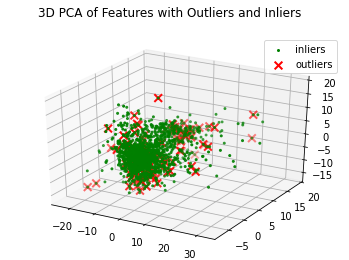

In [10]:
predicted = isolation_forest(X_train, y_train)
non_outlier_indices = []
i = 0
for prediction in predicted:
  if prediction != -1:
    non_outlier_indices.append(i)
  i = i + 1

num_outliers = len(predicted) - len(non_outlier_indices)
print("Num Outliers:", num_outliers)

X_train = X_train[non_outlier_indices]
y_train = y_train.iloc[non_outlier_indices]

Define model

In [11]:
import torch.nn as nn

class metabric_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(691, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)

        return x

In [12]:
num_classes = len(list(set(y_train)))
model = metabric_model(num_classes)

In [13]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def train_model(config, data, epochs=10, batch_size=32):
  X_train = data[0]
  y_train = data[1]
  X_val = data[2]
  y_val = data[3]
  y_train = y_train.to_numpy()
  y_val = y_val.to_numpy()
  X_val = torch.from_numpy(X_val).type(torch.float)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    running_loss = 0.0
    for i in range((X_train.shape[0]-1)//batch_size + 1):
      start_i = i*batch_size
      end_i = start_i+batch_size
      xb = torch.from_numpy(X_train[start_i:end_i]).type(torch.float)
      yb = torch.from_numpy(y_train[start_i:end_i])
      
      pred = model(xb)
      loss = criterion(pred, yb)

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      running_loss += loss.item()
      pred = model(X_val).detach().numpy().astype(np.float)
      pred = np.argmax(pred, axis=1)
      accuracy = accuracy_score(y_val, pred)
      f1 = f1_score(y_val, pred, average='micro')
      print('Completed training batch', epoch, 'Training Loss is: %.4f' %running_loss, 'Accuracy: %.4f' %accuracy, 'F1: %.4f' %f1)
      tune.report(loss=running_loss, accuracy=accuracy)
      running_loss = 0.0

  return model

Use Raytune to determine hyperparameters

In [14]:
import ray
from ray import tune
from ray.tune.schedulers.async_hyperband import ASHAScheduler

config = {
    'epochs':tune.choice([50, 100, 150]),
    'batch_size':tune.choice([8, 16, 32, 64]),
    'lr':tune.loguniform(1e-3, 1e-1),
}
scheduler = ASHAScheduler(
    max_t=10,
    grace_period=1,
    reduction_factor=3
)
result = tune.run(
    tune.with_parameters(train_model, data=[X_train, y_train, X_val, y_val]),
    resources_per_trial={"cpu":2},
    config=config,
    metric="loss",
    mode="min",
    num_samples=10,
    scheduler=scheduler
)
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result['accuracy']))

2022-06-30 05:03:20,405	WARNING function_runner.py:604 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-06-30 05:03:20,506	INFO logger.py:630 -- pip install "ray[tune]" to see TensorBoard files.
2022-06-30 05:03:20,510	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,batch_size,epochs,lr
train_model_f5f2b_00000,RUNNING,172.28.0.2:6540,8,50,0.0183244
train_model_f5f2b_00001,PENDING,,64,50,0.00714125
train_model_f5f2b_00002,PENDING,,16,100,0.00413897
train_model_f5f2b_00003,PENDING,,8,150,0.0371392
train_model_f5f2b_00004,PENDING,,32,100,0.00271683
train_model_f5f2b_00005,PENDING,,64,50,0.0178751
train_model_f5f2b_00006,PENDING,,16,50,0.00966672
train_model_f5f2b_00007,PENDING,,16,150,0.0288953
train_model_f5f2b_00008,PENDING,,8,50,0.0111743
train_model_f5f2b_00009,PENDING,,8,100,0.00103053


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
(train_model pid=6540)   import ray._private.utils
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://n

Result for train_model_f5f2b_00000:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-24
  done: false
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 1
  loss: 0.558618426322937
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.15932917594909668
  time_this_iter_s: 0.15932917594909668
  time_total_s: 0.15932917594909668
  timestamp: 1656565404
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f5f2b_00000
  warmup_time: 0.007794618606567383
  
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5586 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5767 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5590 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5944 Accuracy: 0.7749 F1: 0.7749


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5627 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5406 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5804 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.6263 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00000:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-24
  done: true
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.5112920999526978
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.6666176319122314
  time_this_iter_s: 0.028511762619018555
  time_total_s: 0.6666176319122314
  timestamp: 1656565404
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f5f2b_00000
  warmup_time: 0.007794618606567383
  


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5848 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5113 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00001:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-25
  done: false
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 1
  loss: 0.44083839654922485
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.0695185661315918
  time_this_iter_s: 0.0695185661315918
  time_total_s: 0.0695185661315918
  timestamp: 1656565405
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f5f2b_00001
  warmup_time: 0.007794618606567383
  
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4408 Accuracy: 0.7749 F1: 0.7749


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4685 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4049 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5361 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4350 Accuracy: 0.7749 F1: 0.7749


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3728 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5705 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.7423 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00001:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-25
  done: true
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 9
  loss: 0.5951870679855347
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.5606815814971924
  time_this_iter_s: 0.0714864730834961
  time_total_s: 0.5606815814971924
  timestamp: 1656565405
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: f5f2b_00001
  warmup_time: 0.007794618606567383
  
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5952 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00002:
  accuracy: 0.7748691099

(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3404 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4360 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3743 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5801 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4331 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3733 Accuracy: 0.7749 F1: 0.7749


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5282 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.6575 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5627 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00002:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-25
  done: true
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.4518635869026184
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.3842966556549072
  time_this_iter_s: 0.04761934280395508
  time_total_s: 0.3842966556549072
  timestamp: 1656565405
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f5f2b_00002
  warmup_time: 0.007794618606567383
  
Result for train_model_f5f2b_00003:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-25
  done: false
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  

(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Trial name,status,loc,batch_size,epochs,lr,iter,total time (s),loss,accuracy
train_model_f5f2b_00003,RUNNING,172.28.0.2:6540,8,150,0.0371392,3,0.0951574,0.376094,0.774869
train_model_f5f2b_00004,PENDING,,32,100,0.00271683,,,,
train_model_f5f2b_00005,PENDING,,64,50,0.0178751,,,,
train_model_f5f2b_00006,PENDING,,16,50,0.00966672,,,,
train_model_f5f2b_00007,PENDING,,16,150,0.0288953,,,,
train_model_f5f2b_00008,PENDING,,8,50,0.0111743,,,,
train_model_f5f2b_00009,PENDING,,8,100,0.00103053,,,,
train_model_f5f2b_00000,TERMINATED,172.28.0.2:6540,8,50,0.0183244,10,0.666618,0.511292,0.774869
train_model_f5f2b_00001,TERMINATED,172.28.0.2:6540,64,50,0.00714125,9,0.560682,0.595187,0.774869
train_model_f5f2b_00002,TERMINATED,172.28.0.2:6540,16,100,0.00413897,10,0.384297,0.451864,0.774869


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4382 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3761 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5695 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4339 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00003:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-26
  done: true
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.43515005707740784
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.2511601448059082
  time_this_iter_s: 0.021027803421020508
  time_total_s: 0.2511601448059082
  timestamp: 1656565406
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f5f2b_00003
  warmup_time: 0.007794618606567383
  
(train_model pid=6540) Completed training batch 0 Train

(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3718 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4277 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3689 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5881 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4316 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3613 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5347 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.6747 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00004:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-26
  done: true
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b7460

(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5648 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4380 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3804 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00006:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-26
  done: false
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 1
  loss: 0.3410201370716095
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.037558555603027344
  time_this_iter_s: 0.037558555603027344
  time_total_s: 0.037558555603027344
  timestamp: 1656565406
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: f5f2b_00006
  warmup_time: 0.007794618606567383
  
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3410 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Tra

(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3590 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5223 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.6556 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5582 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00006:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-26
  done: true
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.43730345368385315
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.23603105545043945
  time_this_iter_s: 0.026603221893310547
  time_total_s: 0.23603105545043945
  timestamp: 1656565406
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f5f2b_00006
  warmup_time: 0.007794618606567383
  
Result for train_model_f5f2b_00007:
  accuracy: 0.774

(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4147 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3629 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.5884 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.4187 Accuracy: 0.7749 F1: 0.7749
(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3516 Accuracy: 0.7749 F1: 0.7749
Result for train_model_f5f2b_00008:
  accuracy: 0.774869109947644
  date: 2022-06-30_05-03-27
  done: true
  experiment_id: 2cd3a26f9b614b878a767c9b3553745a
  hostname: 71b746061450
  iterations_since_restore: 10
  loss: 0.42839229106903076
  node_ip: 172.28.0.2
  pid: 6540
  time_since_restore: 0.23619413375854492
  time_this_iter_s: 0.02302837371826172
  time_total_s: 0.23619413375854492
  timestamp: 1656565407
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: f5

(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Trial name,status,loc,batch_size,epochs,lr,iter,total time (s),loss,accuracy
train_model_f5f2b_00000,TERMINATED,172.28.0.2:6540,8,50,0.0183244,10,0.666618,0.511292,0.774869
train_model_f5f2b_00001,TERMINATED,172.28.0.2:6540,64,50,0.00714125,9,0.560682,0.595187,0.774869
train_model_f5f2b_00002,TERMINATED,172.28.0.2:6540,16,100,0.00413897,10,0.384297,0.451864,0.774869
train_model_f5f2b_00003,TERMINATED,172.28.0.2:6540,8,150,0.0371392,10,0.25116,0.43515,0.774869
train_model_f5f2b_00004,TERMINATED,172.28.0.2:6540,32,100,0.00271683,10,0.232667,0.437988,0.774869
train_model_f5f2b_00005,TERMINATED,172.28.0.2:6540,64,50,0.0178751,1,0.0193875,0.380405,0.774869
train_model_f5f2b_00006,TERMINATED,172.28.0.2:6540,16,50,0.00966672,10,0.236031,0.437303,0.774869
train_model_f5f2b_00007,TERMINATED,172.28.0.2:6540,16,150,0.0288953,1,0.0200057,0.383865,0.774869
train_model_f5f2b_00008,TERMINATED,172.28.0.2:6540,8,50,0.0111743,10,0.236194,0.428392,0.774869
train_model_f5f2b_00009,TERMINATED,172.28.0.2:6540,8,100,0.00103053,1,0.0289023,0.377031,0.774869


(train_model pid=6540) Completed training batch 0 Training Loss is: 0.3770 Accuracy: 0.7749 F1: 0.7749


(train_model pid=6540) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=6540) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=6540)   )
2022-06-30 05:03:27,358	INFO tune.py:748 -- Total run time: 6.96 seconds (6.58 seconds for the tuning loop).


Best trial config: {'epochs': 100, 'batch_size': 8, 'lr': 0.0010305329055623578}
Best trial final validation loss: 0.3770310878753662
Best trial final validation accuracy: 0.774869109947644


In [15]:
train_model(config=best_trial, data=[X_train, y_train, X_val, y_val])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 0 Training Loss is: 0.5586 Accuracy: 0.7749 F1: 0.7749


2022-06-30 05:03:27,921	WARNING session.py:35 -- Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
2022-06-30 05:03:27,923	WARNING session.py:38 --   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib

Completed training batch 0 Training Loss is: 0.5767 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5590 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5944 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.5627 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5406 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5804 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6263 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5848 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5113 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.5689 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5337 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4527 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.5280 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.3268 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4400 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4495 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.4511 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.7085 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.7229 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.7274 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5656 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4576 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.4394 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5355 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5396 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.5936 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4702 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4962 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.5447 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5182 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.6428 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.5664 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4345 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4528 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.5013 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4335 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4223 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6303 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.5594 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.6431 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.6059 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.4747 Accuracy: 0.7749 F1: 0.7749
Completed training batch 0 Training Loss is: 0.3957 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.3405 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.4266 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.3770 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.5391 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.4212 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.3606 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.5425 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.7135 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5832 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.4144 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5547 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5207 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.4342 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5130 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.3692 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.4420 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.4424 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.4383 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.5882 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.6179 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.6695 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.5518 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.4380 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.3956 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.5050 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5092 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5882 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.3803 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.4156 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5012 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.4541 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.6728 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.5425 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.3255 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.3638 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.4493 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.3548 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.3509 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.6367 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.5391 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.6033 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 1 Training Loss is: 0.5653 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 1 Training Loss is: 0.4321 Accuracy: 0.7749 F1: 0.7749
Completed training batch 1 Training Loss is: 0.3795 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.3490 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4020 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3730 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.5109 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3636 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3042 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.4922 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.6542 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.5090 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.3059 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4601 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4827 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.3796 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4495 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.2913 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.3385 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3518 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3079 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.5957 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.5140 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.6493 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.4512 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4097 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3935 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.4336 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4267 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4660 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.2728 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.2711 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4279 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.3792 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.5948 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4639 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.2223 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.2894 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3527 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.2791 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.2719 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3955 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.4183 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.3680 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.4382 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.2804 Accuracy: 0.7749 F1: 0.7749
Completed training batch 2 Training Loss is: 0.2429 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.2699 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.2490 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.3313 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.5842 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.2294 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.2276 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.3837 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.4798 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.3922 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.2502 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.4660 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.4029 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.2895 Accuracy: 0.7749 F1: 0.7749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.3816 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.1476 Accuracy: 0.7749 F1: 0.7749
Completed training batch 3 Training Loss is: 0.1960 Accuracy: 0.7906 F1: 0.7906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.3823 Accuracy: 0.8010 F1: 0.8010
Completed training batch 3 Training Loss is: 0.2407 Accuracy: 0.8115 F1: 0.8115
Completed training batch 3 Training Loss is: 0.6671 Accuracy: 0.8377 F1: 0.8377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.3942 Accuracy: 0.8639 F1: 0.8639
Completed training batch 3 Training Loss is: 0.6111 Accuracy: 0.8220 F1: 0.8220
Completed training batch 3 Training Loss is: 0.3599 Accuracy: 0.7382 F1: 0.7382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.4808 Accuracy: 0.7016 F1: 0.7016
Completed training batch 3 Training Loss is: 0.4950 Accuracy: 0.7539 F1: 0.7539
Completed training batch 3 Training Loss is: 0.3716 Accuracy: 0.8115 F1: 0.8115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.3792 Accuracy: 0.8482 F1: 0.8482
Completed training batch 3 Training Loss is: 0.3953 Accuracy: 0.8691 F1: 0.8691
Completed training batch 3 Training Loss is: 0.2205 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.2270 Accuracy: 0.8220 F1: 0.8220
Completed training batch 3 Training Loss is: 0.3846 Accuracy: 0.8220 F1: 0.8220
Completed training batch 3 Training Loss is: 0.3352 Accuracy: 0.8220 F1: 0.8220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.5224 Accuracy: 0.8220 F1: 0.8220
Completed training batch 3 Training Loss is: 0.3871 Accuracy: 0.8429 F1: 0.8429
Completed training batch 3 Training Loss is: 0.2137 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.2764 Accuracy: 0.8743 F1: 0.8743
Completed training batch 3 Training Loss is: 0.3233 Accuracy: 0.8691 F1: 0.8691
Completed training batch 3 Training Loss is: 0.2449 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.2482 Accuracy: 0.8743 F1: 0.8743
Completed training batch 3 Training Loss is: 0.2968 Accuracy: 0.8691 F1: 0.8691
Completed training batch 3 Training Loss is: 0.3806 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.2685 Accuracy: 0.8429 F1: 0.8429
Completed training batch 3 Training Loss is: 0.3424 Accuracy: 0.8429 F1: 0.8429
Completed training batch 3 Training Loss is: 0.2676 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.2234 Accuracy: 0.8377 F1: 0.8377
Completed training batch 4 Training Loss is: 0.2865 Accuracy: 0.8534 F1: 0.8534
Completed training batch 4 Training Loss is: 0.2248 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3155 Accuracy: 0.8743 F1: 0.8743
Completed training batch 4 Training Loss is: 0.6200 Accuracy: 0.8743 F1: 0.8743
Completed training batch 4 Training Loss is: 0.1812 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.1082 Accuracy: 0.8743 F1: 0.8743
Completed training batch 4 Training Loss is: 0.4430 Accuracy: 0.8743 F1: 0.8743
Completed training batch 4 Training Loss is: 0.5213 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3314 Accuracy: 0.8586 F1: 0.8586
Completed training batch 4 Training Loss is: 0.1216 Accuracy: 0.8429 F1: 0.8429
Completed training batch 4 Training Loss is: 0.3851 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.4207 Accuracy: 0.8220 F1: 0.8220
Completed training batch 4 Training Loss is: 0.3633 Accuracy: 0.8429 F1: 0.8429
Completed training batch 4 Training Loss is: 0.4002 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.2077 Accuracy: 0.8586 F1: 0.8586
Completed training batch 4 Training Loss is: 0.2457 Accuracy: 0.8586 F1: 0.8586
Completed training batch 4 Training Loss is: 0.2512 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.1955 Accuracy: 0.8377 F1: 0.8377
Completed training batch 4 Training Loss is: 0.4794 Accuracy: 0.8534 F1: 0.8534
Completed training batch 4 Training Loss is: 0.3175 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.5842 Accuracy: 0.8691 F1: 0.8691
Completed training batch 4 Training Loss is: 0.4010 Accuracy: 0.8429 F1: 0.8429
Completed training batch 4 Training Loss is: 0.3664 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3734 Accuracy: 0.8482 F1: 0.8482
Completed training batch 4 Training Loss is: 0.2448 Accuracy: 0.8534 F1: 0.8534
Completed training batch 4 Training Loss is: 0.3319 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3729 Accuracy: 0.8639 F1: 0.8639
Completed training batch 4 Training Loss is: 0.1786 Accuracy: 0.8691 F1: 0.8691
Completed training batch 4 Training Loss is: 0.2015 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3546 Accuracy: 0.8691 F1: 0.8691
Completed training batch 4 Training Loss is: 0.2787 Accuracy: 0.8534 F1: 0.8534
Completed training batch 4 Training Loss is: 0.3992 Accuracy: 0.8534 F1: 0.8534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3383 Accuracy: 0.8534 F1: 0.8534
Completed training batch 4 Training Loss is: 0.1993 Accuracy: 0.8586 F1: 0.8586
Completed training batch 4 Training Loss is: 0.2564 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3183 Accuracy: 0.8639 F1: 0.8639
Completed training batch 4 Training Loss is: 0.1866 Accuracy: 0.8691 F1: 0.8691
Completed training batch 4 Training Loss is: 0.2278 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.3192 Accuracy: 0.8586 F1: 0.8586
Completed training batch 4 Training Loss is: 0.3564 Accuracy: 0.8639 F1: 0.8639
Completed training batch 4 Training Loss is: 0.1965 Accuracy: 0.8482 F1: 0.8482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.2643 Accuracy: 0.8168 F1: 0.8168
Completed training batch 4 Training Loss is: 0.2924 Accuracy: 0.8429 F1: 0.8429
Completed training batch 4 Training Loss is: 0.1813 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2915 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.2216 Accuracy: 0.8691 F1: 0.8691
Completed training batch 5 Training Loss is: 0.3078 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.6235 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.1490 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.0716 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.3952 Accuracy: 0.8691 F1: 0.8691
Completed training batch 5 Training Loss is: 0.4094 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.2850 Accuracy: 0.8272 F1: 0.8272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1440 Accuracy: 0.7749 F1: 0.7749
Completed training batch 5 Training Loss is: 0.4159 Accuracy: 0.7592 F1: 0.7592
Completed training batch 5 Training Loss is: 0.4393 Accuracy: 0.8063 F1: 0.8063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.3404 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.3618 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.1543 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1670 Accuracy: 0.8168 F1: 0.8168
Completed training batch 5 Training Loss is: 0.2675 Accuracy: 0.8063 F1: 0.8063
Completed training batch 5 Training Loss is: 0.2059 Accuracy: 0.8010 F1: 0.8010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.6276 Accuracy: 0.8063 F1: 0.8063
Completed training batch 5 Training Loss is: 0.3694 Accuracy: 0.8482 F1: 0.8482
Completed training batch 5 Training Loss is: 0.5852 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.3204 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.3483 Accuracy: 0.8063 F1: 0.8063
Completed training batch 5 Training Loss is: 0.4114 Accuracy: 0.8168 F1: 0.8168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.3132 Accuracy: 0.8377 F1: 0.8377
Completed training batch 5 Training Loss is: 0.3580 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.3205 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1820 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.2067 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.3372 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2544 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.4302 Accuracy: 0.8796 F1: 0.8796
Completed training batch 5 Training Loss is: 0.3026 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2090 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.2743 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.2911 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1520 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.2143 Accuracy: 0.8639 F1: 0.8639
Completed training batch 5 Training Loss is: 0.1849 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.3691 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.1537 Accuracy: 0.8534 F1: 0.8534
Completed training batch 5 Training Loss is: 0.2253 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1903 Accuracy: 0.8586 F1: 0.8586
Completed training batch 5 Training Loss is: 0.1103 Accuracy: 0.8586 F1: 0.8586
Completed training batch 6 Training Loss is: 0.2666 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2123 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.3103 Accuracy: 0.8639 F1: 0.8639
Completed training batch 6 Training Loss is: 0.6174 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1218 Accuracy: 0.8639 F1: 0.8639
Completed training batch 6 Training Loss is: 0.0540 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.4182 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.4657 Accuracy: 0.8586 F1: 0.8586
Completed training batch 6 Training Loss is: 0.2865 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.0849 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.3679 Accuracy: 0.8534 F1: 0.8534
Completed training batch 6 Training Loss is: 0.3280 Accuracy: 0.8534 F1: 0.8534
Completed training batch 6 Training Loss is: 0.2870 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.3537 Accuracy: 0.8534 F1: 0.8534
Completed training batch 6 Training Loss is: 0.1541 Accuracy: 0.8639 F1: 0.8639
Completed training batch 6 Training Loss is: 0.1580 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2012 Accuracy: 0.8639 F1: 0.8639
Completed training batch 6 Training Loss is: 0.1429 Accuracy: 0.8482 F1: 0.8482
Completed training batch 6 Training Loss is: 0.4803 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2490 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.5195 Accuracy: 0.8534 F1: 0.8534
Completed training batch 6 Training Loss is: 0.2885 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.3298 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.3437 Accuracy: 0.8639 F1: 0.8639
Completed training batch 6 Training Loss is: 0.2147 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2910 Accuracy: 0.8743 F1: 0.8743
Completed training batch 6 Training Loss is: 0.3724 Accuracy: 0.8743 F1: 0.8743
Completed training batch 6 Training Loss is: 0.1557 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1515 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.3171 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.1916 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.3382 Accuracy: 0.8691 F1: 0.8691
Completed training batch 6 Training Loss is: 0.2549 Accuracy: 0.8586 F1: 0.8586
Completed training batch 6 Training Loss is: 0.2827 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2999 Accuracy: 0.8743 F1: 0.8743
Completed training batch 6 Training Loss is: 0.2571 Accuracy: 0.8586 F1: 0.8586
Completed training batch 6 Training Loss is: 0.1293 Accuracy: 0.8482 F1: 0.8482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2075 Accuracy: 0.8377 F1: 0.8377
Completed training batch 6 Training Loss is: 0.2603 Accuracy: 0.8586 F1: 0.8586
Completed training batch 6 Training Loss is: 0.3493 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1671 Accuracy: 0.8534 F1: 0.8534
Completed training batch 6 Training Loss is: 0.1578 Accuracy: 0.8325 F1: 0.8325
Completed training batch 6 Training Loss is: 0.2985 Accuracy: 0.8325 F1: 0.8325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1347 Accuracy: 0.8482 F1: 0.8482
Completed training batch 7 Training Loss is: 0.2604 Accuracy: 0.8534 F1: 0.8534
Completed training batch 7 Training Loss is: 0.1698 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.3168 Accuracy: 0.8743 F1: 0.8743
Completed training batch 7 Training Loss is: 0.5681 Accuracy: 0.8691 F1: 0.8691
Completed training batch 7 Training Loss is: 0.0836 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0451 Accuracy: 0.8691 F1: 0.8691
Completed training batch 7 Training Loss is: 0.3088 Accuracy: 0.8534 F1: 0.8534
Completed training batch 7 Training Loss is: 0.3133 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.2534 Accuracy: 0.8429 F1: 0.8429
Completed training batch 7 Training Loss is: 0.0920 Accuracy: 0.8482 F1: 0.8482
Completed training batch 7 Training Loss is: 0.3628 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.2733 Accuracy: 0.8586 F1: 0.8586
Completed training batch 7 Training Loss is: 0.2238 Accuracy: 0.8796 F1: 0.8796
Completed training batch 7 Training Loss is: 0.3099 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.1319 Accuracy: 0.8534 F1: 0.8534
Completed training batch 7 Training Loss is: 0.1033 Accuracy: 0.8272 F1: 0.8272
Completed training batch 7 Training Loss is: 0.2111 Accuracy: 0.8272 F1: 0.8272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.1258 Accuracy: 0.8272 F1: 0.8272
Completed training batch 7 Training Loss is: 0.5144 Accuracy: 0.8586 F1: 0.8586
Completed training batch 7 Training Loss is: 0.1976 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.4566 Accuracy: 0.8586 F1: 0.8586
Completed training batch 7 Training Loss is: 0.3040 Accuracy: 0.8220 F1: 0.8220
Completed training batch 7 Training Loss is: 0.3913 Accuracy: 0.8115 F1: 0.8115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.4178 Accuracy: 0.8534 F1: 0.8534
Completed training batch 7 Training Loss is: 0.2295 Accuracy: 0.8796 F1: 0.8796
Completed training batch 7 Training Loss is: 0.2685 Accuracy: 0.8534 F1: 0.8534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.3547 Accuracy: 0.8482 F1: 0.8482
Completed training batch 7 Training Loss is: 0.1442 Accuracy: 0.8325 F1: 0.8325
Completed training batch 7 Training Loss is: 0.1595 Accuracy: 0.8325 F1: 0.8325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.3220 Accuracy: 0.8482 F1: 0.8482
Completed training batch 7 Training Loss is: 0.2055 Accuracy: 0.8639 F1: 0.8639
Completed training batch 7 Training Loss is: 0.3798 Accuracy: 0.8796 F1: 0.8796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.2464 Accuracy: 0.8691 F1: 0.8691
Completed training batch 7 Training Loss is: 0.2711 Accuracy: 0.8639 F1: 0.8639
Completed training batch 7 Training Loss is: 0.3382 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.2383 Accuracy: 0.8639 F1: 0.8639
Completed training batch 7 Training Loss is: 0.1430 Accuracy: 0.8743 F1: 0.8743
Completed training batch 7 Training Loss is: 0.1916 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.1590 Accuracy: 0.8639 F1: 0.8639
Completed training batch 7 Training Loss is: 0.3370 Accuracy: 0.8586 F1: 0.8586
Completed training batch 7 Training Loss is: 0.2334 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.2013 Accuracy: 0.8796 F1: 0.8796
Completed training batch 7 Training Loss is: 0.1884 Accuracy: 0.8639 F1: 0.8639
Completed training batch 7 Training Loss is: 0.0910 Accuracy: 0.8220 F1: 0.8220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.3151 Accuracy: 0.8377 F1: 0.8377
Completed training batch 8 Training Loss is: 0.2126 Accuracy: 0.8639 F1: 0.8639
Completed training batch 8 Training Loss is: 0.3004 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.4608 Accuracy: 0.8691 F1: 0.8691
Completed training batch 8 Training Loss is: 0.0730 Accuracy: 0.8796 F1: 0.8796
Completed training batch 8 Training Loss is: 0.0290 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.4788 Accuracy: 0.8639 F1: 0.8639
Completed training batch 8 Training Loss is: 0.4300 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.2701 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0766 Accuracy: 0.8377 F1: 0.8377
Completed training batch 8 Training Loss is: 0.3303 Accuracy: 0.8220 F1: 0.8220
Completed training batch 8 Training Loss is: 0.3239 Accuracy: 0.8220 F1: 0.8220


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.2814 Accuracy: 0.8429 F1: 0.8429
Completed training batch 8 Training Loss is: 0.3282 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.1406 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1137 Accuracy: 0.8325 F1: 0.8325
Completed training batch 8 Training Loss is: 0.1823 Accuracy: 0.8220 F1: 0.8220
Completed training batch 8 Training Loss is: 0.1274 Accuracy: 0.8272 F1: 0.8272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.5949 Accuracy: 0.8272 F1: 0.8272
Completed training batch 8 Training Loss is: 0.2767 Accuracy: 0.8325 F1: 0.8325
Completed training batch 8 Training Loss is: 0.5650 Accuracy: 0.8586 F1: 0.8586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.2374 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.2717 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.2989 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.2279 Accuracy: 0.8796 F1: 0.8796
Completed training batch 8 Training Loss is: 0.2883 Accuracy: 0.8796 F1: 0.8796
Completed training batch 8 Training Loss is: 0.2269 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1309 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.1538 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.3118 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1579 Accuracy: 0.8639 F1: 0.8639
Completed training batch 8 Training Loss is: 0.3700 Accuracy: 0.8586 F1: 0.8586
Completed training batch 8 Training Loss is: 0.2073 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.2071 Accuracy: 0.8639 F1: 0.8639
Completed training batch 8 Training Loss is: 0.2532 Accuracy: 0.8639 F1: 0.8639
Completed training batch 8 Training Loss is: 0.2361 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0835 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.1810 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.0667 Accuracy: 0.8796 F1: 0.8796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.3823 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.1151 Accuracy: 0.8743 F1: 0.8743
Completed training batch 8 Training Loss is: 0.1069 Accuracy: 0.8796 F1: 0.8796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1666 Accuracy: 0.8796 F1: 0.8796
Completed training batch 8 Training Loss is: 0.0703 Accuracy: 0.8796 F1: 0.8796
Completed training batch 9 Training Loss is: 0.2211 Accuracy: 0.8796 F1: 0.8796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1333 Accuracy: 0.8743 F1: 0.8743
Completed training batch 9 Training Loss is: 0.2866 Accuracy: 0.8691 F1: 0.8691
Completed training batch 9 Training Loss is: 0.4602 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0748 Accuracy: 0.8586 F1: 0.8586
Completed training batch 9 Training Loss is: 0.0219 Accuracy: 0.8482 F1: 0.8482
Completed training batch 9 Training Loss is: 0.3605 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.2969 Accuracy: 0.8848 F1: 0.8848
Completed training batch 9 Training Loss is: 0.1901 Accuracy: 0.8534 F1: 0.8534
Completed training batch 9 Training Loss is: 0.0843 Accuracy: 0.8325 F1: 0.8325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.3196 Accuracy: 0.8272 F1: 0.8272
Completed training batch 9 Training Loss is: 0.2482 Accuracy: 0.8691 F1: 0.8691
Completed training batch 9 Training Loss is: 0.1951 Accuracy: 0.8691 F1: 0.8691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.2952 Accuracy: 0.8586 F1: 0.8586
Completed training batch 9 Training Loss is: 0.1373 Accuracy: 0.8377 F1: 0.8377
Completed training batch 9 Training Loss is: 0.0852 Accuracy: 0.8325 F1: 0.8325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1746 Accuracy: 0.8272 F1: 0.8272
Completed training batch 9 Training Loss is: 0.1257 Accuracy: 0.8272 F1: 0.8272
Completed training batch 9 Training Loss is: 0.5093 Accuracy: 0.8325 F1: 0.8325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.2011 Accuracy: 0.8534 F1: 0.8534
Completed training batch 9 Training Loss is: 0.4466 Accuracy: 0.8848 F1: 0.8848
Completed training batch 9 Training Loss is: 0.2361 Accuracy: 0.8377 F1: 0.8377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.3175 Accuracy: 0.8325 F1: 0.8325
Completed training batch 9 Training Loss is: 0.3797 Accuracy: 0.8534 F1: 0.8534
Completed training batch 9 Training Loss is: 0.2310 Accuracy: 0.8743 F1: 0.8743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.2538 Accuracy: 0.8429 F1: 0.8429
Completed training batch 9 Training Loss is: 0.2824 Accuracy: 0.8482 F1: 0.8482
Completed training batch 9 Training Loss is: 0.1201 Accuracy: 0.8272 F1: 0.8272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1203 Accuracy: 0.8325 F1: 0.8325
Completed training batch 9 Training Loss is: 0.3007 Accuracy: 0.8325 F1: 0.8325
Completed training batch 9 Training Loss is: 0.1964 Accuracy: 0.8429 F1: 0.8429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.3741 Accuracy: 0.8534 F1: 0.8534
Completed training batch 9 Training Loss is: 0.1888 Accuracy: 0.8743 F1: 0.8743
Completed training batch 9 Training Loss is: 0.2378 Accuracy: 0.8796 F1: 0.8796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.3257 Accuracy: 0.8796 F1: 0.8796
Completed training batch 9 Training Loss is: 0.2047 Accuracy: 0.8691 F1: 0.8691
Completed training batch 9 Training Loss is: 0.1066 Accuracy: 0.8639 F1: 0.8639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1570 Accuracy: 0.8482 F1: 0.8482
Completed training batch 9 Training Loss is: 0.1140 Accuracy: 0.8586 F1: 0.8586
Completed training batch 9 Training Loss is: 0.3027 Accuracy: 0.8482 F1: 0.8482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.2070 Accuracy: 0.8482 F1: 0.8482
Completed training batch 9 Training Loss is: 0.1537 Accuracy: 0.8586 F1: 0.8586
Completed training batch 9 Training Loss is: 0.1739 Accuracy: 0.8848 F1: 0.8848
Completed training batch 9 Training Loss is: 0.0669 Accuracy: 0.8482 F1: 0.8482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


metabric_model(
  (relu): ReLU()
  (fc1): Linear(in_features=691, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=2, bias=True)
)

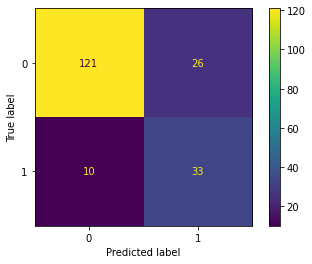

In [22]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_test = torch.from_numpy(X_test).type(torch.float)
pred = model(X_test).detach().numpy()
pred = np.argmax(pred, axis=1)

ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
plt.show()